### Multimodal Classification: text + tabular + image
### Early fusion NN + Feature fusion with XGBoost and SVM

In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.svm import LinearSVC

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, Bidirectional, LSTM,
    Dense, Dropout, Concatenate, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.preprocessing import image as keras_image

In [ ]:
"""my plan is to first perform early fusion between the tabular features and the
 text data (using tokenized text as input). This combined representation will be fed 
 into a suitable neural network. In parallel, the image data will be processed using a 
 pretrained neural network to extract visual features. Finally, I will apply feature-level 
 fusion between the learned representations from the text–tabular model and the image model, and use the 
 fused features as input to XGBoost and SVM classifiers for final prediction."""

'my plan is to first perform early fusion between the tabular features and the\n text data (using tokenized text as input). This combined representation will be fed into a suitable neural network. In parallel, the image data will be processed using a pretrained neural network to extract visual features. Finally, I will apply feature-level fusion between the learned representations from the text–tabular model and the image model, and use the fused features as input to XGBoost and SVM classifiers for final prediction.'

In [5]:
df = pd.read_csv("FoodFactsCleaned.csv")

In [6]:
TEXT_COLS = [
    "brand_cleaned",
    "allergens_cleaned",
    "ingredients_text_cleaned",
    "countries_cleaned",
    "additives_cleaned",
]

TABULAR_COLS = [
    'nova_group', 'fat_100g',
    'saturated_fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
    'proteins_100g', 'contains_palm_oil', 'vegetarian_status', 'vegan_status',
    'nutrient_level_fat', 'nutrient_level_saturated_fat',
    'nutrient_level_sugars', 'nutrient_level_salt', 'ecoscore_grade', 'ecoscore_score',
    'carbon_footprint_100g', 'additives_count', 'sugar_ratio',
    'energy_density', 'protein_ratio', 'macro_balance', 'healthy_score',
    'log_energy_kcal_100g', 'log_salt_100g'
]

TARGET_COL = "nutriscore_letter"         
IMAGE_PATH_COL = "image_160_path"  
RANDOM_STATE = 42
TEST_SIZE = 0.2

# Text tokenization
MAX_WORDS = 30000
MAX_LEN = 200

In [7]:
for c in TEXT_COLS:
    df[c] = df[c].fillna("").astype(str)

df["text_concat"] = df[TEXT_COLS].agg(" ".join, axis=1)

print("Rows after image path filtering:", len(df))

Rows after image path filtering: 5138


In [47]:
X_text = df["text_concat"].values
X_tab = df[TABULAR_COLS].values
X_img_paths = df[IMAGE_PATH_COL].astype(str).values
y = df[TARGET_COL].values



X_text_tv, X_text_te, X_tab_tv, X_tab_te, X_img_tv, X_img_te, y_tv, y_te = train_test_split(
    X_text, X_tab, X_img_paths, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

# Second split: Train vs Val
X_text_tr, X_text_val, X_tab_tr, X_tab_val, X_img_tr, X_img_val, y_tr, y_val = train_test_split(
    X_text_tv, X_tab_tv, X_img_tv, y_tv,
    test_size=0.25,  
    random_state=RANDOM_STATE,
    stratify=y_tv
)

num_classes = len(np.unique(y))
print("Train:", len(y_tr), "val:", len(y_val), "Test:", len(y_te), "Classes:", num_classes)

Train: 3082 val: 1028 Test: 1028 Classes: 5


In [48]:
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_text_tr)

seq_tr  = tokenizer.texts_to_sequences(X_text_tr)
seq_val = tokenizer.texts_to_sequences(X_text_val)
seq_te  = tokenizer.texts_to_sequences(X_text_te)

X_text_tr_pad = pad_sequences(
    seq_tr, maxlen=MAX_LEN, padding="post", truncating="post"
)

X_text_val_pad = pad_sequences(
    seq_val, maxlen=MAX_LEN, padding="post", truncating="post"
)

X_text_te_pad = pad_sequences(
    seq_te, maxlen=MAX_LEN, padding="post", truncating="post"
)

vocab_size = min(MAX_WORDS, len(tokenizer.word_index) + 1)

scaler = StandardScaler()
X_tab_tr_scaled = scaler.fit_transform(X_tab_tr)
X_tab_val_scaled = scaler.transform(X_tab_val)
X_tab_te_scaled = scaler.transform(X_tab_te)

In [49]:
def build_text_tab_model(vocab_size, max_len, tab_dim, num_classes):
    # Text branch
    text_in = Input(shape=(max_len,), name="text_in")
    x_text = Embedding(
        input_dim=vocab_size,
        output_dim=128,
        input_length=max_len
    )(text_in)

    x_text = GlobalAveragePooling1D()(x_text)
    x_text = Dropout(0.3)(x_text)

    # Tabular branch
    tab_in = Input(shape=(tab_dim,), name="tab_in")
    x_tab = Dense(64, activation="relu")(tab_in)
    x_tab = Dropout(0.3)(x_tab)
    x_tab = Dense(32, activation="relu")(x_tab)

    # Early fusion
    fused = Concatenate()([x_text, x_tab])
    fused = Dense(128, activation="relu", name="text_tab_embedding")(fused)
    fused = Dropout(0.4)(fused)

    out = Dense(num_classes, activation="softmax")(fused)
    model = Model(inputs=[text_in, tab_in], outputs=out)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [51]:

tab_dim = X_tab_tr_scaled.shape[1]
text_tab_model = build_text_tab_model(vocab_size, MAX_LEN, tab_dim, num_classes)
text_tab_model.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
]

history = text_tab_model.fit(
    {"text_in": X_text_tr_pad, "tab_in": X_tab_tr_scaled},
    y_tr,
    validation_data=(
        {"text_in": X_text_val_pad, "tab_in": X_tab_val_scaled},
        y_val
    ),
    epochs=20,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_in             │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tab_in (InputLayer) │ (None, 25)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 200, 128)  │  1,650,048 │ text_in[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 64)        │      1,664 │ tab_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ embedding_11[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 64)        │          0 │ dense_36[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 128)       │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 32)        │      2,080 │ dropout_36[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 160)       │          0 │ dropout_35[0][0], │
│ (Concatenate)       │                   │            │ dense_37[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_tab_embedding  │ (None, 128)       │     20,608 │ concatenate_11[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 128)       │          0 │ text_tab_embeddi… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 5)         │        645 │ dropout_37[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,675,045 (6.39 MB)

 Trainable params: 1,675,045 (6.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4912 - loss: 1.1719 - val_accuracy: 0.6984 - val_loss: 0.7848
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6204 - loss: 0.8597 - val_accuracy: 0.7208 - val_loss: 0.6909
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6823 - loss: 0.7562 - val_accuracy: 0.7198 - val_loss: 0.6532
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7067 - loss: 0.6997 - val_accuracy: 0.7296 - val_loss: 0.6292
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7138 - loss: 0.6744 - val_accuracy: 0.7354 - val_loss: 0.6206
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7300 - loss: 0.6561 - val_accuracy: 0.7451 - val_loss: 0.6070
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7424 - loss: 0.6204 - val_accuracy: 0.7529 - val_loss: 0.6005
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7456 - loss: 0.6088 - val_accuracy: 0.7675 - val_loss:

In [61]:
# Feature extractor: outputs the learned text-tab embedding
text_tab_extractor = Model(
    inputs=text_tab_model.inputs,
    outputs=text_tab_model.get_layer("text_tab_embedding").output
)

Z_texttab_tr = text_tab_extractor.predict({"text_in": X_text_tr_pad, "tab_in": X_tab_tr_scaled}, batch_size=256, verbose=0)
Z_texttab_te = text_tab_extractor.predict({"text_in": X_text_te_pad, "tab_in": X_tab_te_scaled}, batch_size=256, verbose=0)
Z_texttab_val = text_tab_extractor.predict({"text_in": X_text_val_pad, "tab_in": X_tab_val_scaled}, batch_size=256, verbose=0)

print("Text-Tab embeddings:", Z_texttab_tr.shape, Z_texttab_te.shape, Z_texttab_val.shape)

Text-Tab embeddings: (3082, 128) (1028, 128) (1028, 128)


In [53]:
IMG_SIZE = 160
BATCH_SIZE = 32

def make_dataset_mobilenet(img_paths, labels, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((img_paths, labels))

    def _load_image(path, label):
        img_bytes = tf.io.read_file(path)
        img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

        if augment:
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, 0.1)
            img = tf.image.random_contrast(img, 0.9, 1.1)

        img = tf.cast(img, tf.float32)
        img = preprocess_input(img)

        return img, label

    ds = ds.map(_load_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=len(img_paths), reshuffle_each_iteration=True)

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds


In [54]:
train_ds_mob = make_dataset_mobilenet_from_split(
    X_img_tr, y_tr, shuffle=True, augment=True
)

val_ds_mob = make_dataset_mobilenet_from_split(
    X_img_val, y_val, shuffle=False, augment=False
)

test_ds_mob = make_dataset_mobilenet_from_split(
    X_img_te, y_te, shuffle=False, augment=False
)


In [40]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

In [41]:
base_model = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)


embedding = layers.Dense(
    128,
    activation="relu",
    name="img_embedding"
)(x)

outputs = layers.Dense(num_classes, activation="softmax")(embedding)

mob_model = models.Model(inputs, outputs)

mob_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

mob_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ img_embedding (Dense)           │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [55]:
history_mob = mob_model.fit(
    train_ds_mob,
    validation_data=val_ds_mob,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=2,
            restore_best_weights=True
        )
    ],
    verbose=1
)

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.3417 - loss: 1.5229 - val_accuracy: 0.3930 - val_loss: 1.4344
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.3686 - loss: 1.4874 - val_accuracy: 0.3813 - val_loss: 1.4344
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.3679 - loss: 1.4629 - val_accuracy: 0.3755 - val_loss: 1.4413


In [56]:
test_loss, test_acc = mob_model.evaluate(test_ds_mob, verbose=0)
print("MobileNetV2 Test Accuracy:", test_acc)


MobileNetV2 Test Accuracy: 0.33949416875839233


In [57]:
feature_extractor_mob = tf.keras.Model(
    inputs=mob_model.input,
    outputs=mob_model.get_layer("img_embedding").output
)


In [58]:
Z_img_tr = feature_extractor_mob.predict(train_ds_mob, verbose=1)
Z_img_val = feature_extractor_mob.predict(val_ds_mob, verbose=1)
Z_img_te = feature_extractor_mob.predict(test_ds_mob, verbose=1)

print("Image embeddings shapes:")
print("Train:", Z_img_tr.shape)
print("Val:  ", Z_img_val.shape)
print("Test: ", Z_img_te.shape)


97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step
Image embeddings shapes:
Train: (3082, 128)
Val:   (1028, 128)
Test:  (1028, 128)


In [62]:
# ---- Fuse features ----
X_fused_tr  = np.hstack([Z_texttab_tr,  Z_img_tr])
X_fused_val = np.hstack([Z_texttab_val, Z_img_val])
X_fused_te  = np.hstack([Z_texttab_te,  Z_img_te])

print("Fused features:")
print("Train:", X_fused_tr.shape)
print("Val:  ", X_fused_val.shape)
print("Test: ", X_fused_te.shape)


Fused features:
Train: (3082, 256)
Val:   (1028, 256)
Test:  (1028, 256)


In [63]:


svm = LinearSVC(
    C=1.0,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

svm.fit(X_fused_tr, y_tr)


,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,verbose,0
,random_state,42


In [70]:
# -------- Linear SVM predictions --------
svm_train_pred = svm.predict(X_fused_tr)
svm_val_pred   = svm.predict(X_fused_val)
svm_test_pred  = svm.predict(X_fused_te)

print("\n=== Linear SVM on fused features ===")
print(f"Train Accuracy: {accuracy_score(y_tr, svm_train_pred):.4f}")
print(f"Val   Accuracy: {accuracy_score(y_val, svm_val_pred):.4f}")
print(f"Test  Accuracy: {accuracy_score(y_te, svm_test_pred):.4f}")

print("\nTest Macro-F1:", f1_score(y_te, svm_test_pred, average="macro"))
print(classification_report(y_te, svm_test_pred))



=== Linear SVM on fused features ===
Train Accuracy: 0.8761
Val   Accuracy: 0.7685
Test  Accuracy: 0.8045

Test Macro-F1: 0.8009230255059556
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       193
           1       0.72      0.71      0.71       197
           2       0.79      0.75      0.77       210
           3       0.79      0.82      0.80       197
           4       0.92      0.91      0.92       231

    accuracy                           0.80      1028
   macro avg       0.80      0.80      0.80      1028
weighted avg       0.80      0.80      0.80      1028



In [77]:

xgb = XGBClassifier(
    n_estimators=20,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="multi:softprob" if num_classes > 2 else "binary:logistic",
    num_class=num_classes if num_classes > 2 else None,
    eval_metric="mlogloss" if num_classes > 2 else "logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

xgb.fit(
    X_fused_tr,
    y_tr,
    eval_set=[(X_fused_val, y_val)],
    verbose=False
)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [78]:
# -------- XGBoost predictions --------
xgb_train_pred = xgb.predict(X_fused_tr)
xgb_val_pred   = xgb.predict(X_fused_val)
xgb_test_pred  = xgb.predict(X_fused_te)

print("\n=== XGBoost on fused features ===")
print(f"Train Accuracy: {accuracy_score(y_tr, xgb_train_pred):.4f}")
print(f"Val   Accuracy: {accuracy_score(y_val, xgb_val_pred):.4f}")
print(f"Test  Accuracy: {accuracy_score(y_te, xgb_test_pred):.4f}")

print("\nTest Macro-F1:", f1_score(y_te, xgb_test_pred, average="macro"))
print(classification_report(y_te, xgb_test_pred))



=== XGBoost on fused features ===
Train Accuracy: 0.8579
Val   Accuracy: 0.7753
Test  Accuracy: 0.7957

Test Macro-F1: 0.7930284658696413
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       193
           1       0.69      0.75      0.72       197
           2       0.79      0.75      0.77       210
           3       0.78      0.81      0.79       197
           4       0.92      0.90      0.91       231

    accuracy                           0.80      1028
   macro avg       0.79      0.79      0.79      1028
weighted avg       0.80      0.80      0.80      1028



In [83]:
# ---- SVM accuracies ----
svm_train_acc = accuracy_score(y_tr, svm.predict(X_fused_tr))
svm_val_acc   = accuracy_score(y_val, svm.predict(X_fused_val))
svm_test_acc  = accuracy_score(y_te, svm.predict(X_fused_te))
# ---- XGBoost accuracies ----
xgb_train_acc = accuracy_score(y_tr, xgb.predict(X_fused_tr))
xgb_val_acc   = accuracy_score(y_val, xgb.predict(X_fused_val))
xgb_test_acc  = accuracy_score(y_te, xgb.predict(X_fused_te))



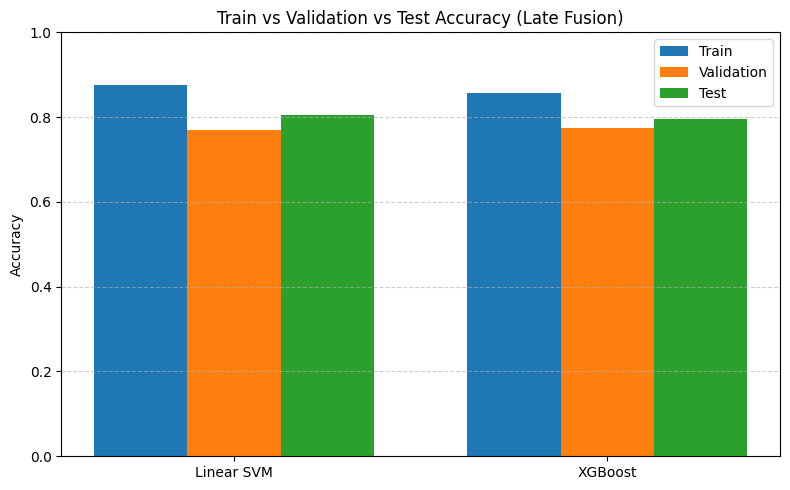

In [84]:
import matplotlib.pyplot as plt
import numpy as np

models = ["Linear SVM", "XGBoost"]
train_acc = [svm_train_acc, xgb_train_acc]
val_acc   = [svm_val_acc,   xgb_val_acc]
test_acc  = [svm_test_acc,  xgb_test_acc]

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(8, 5))
plt.bar(x - width, train_acc, width, label="Train")
plt.bar(x,         val_acc,   width, label="Validation")
plt.bar(x + width, test_acc,  width, label="Test")

plt.xticks(x, models)
plt.ylabel("Accuracy")
plt.title("Train vs Validation vs Test Accuracy (Late Fusion)")
plt.ylim(0, 1)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()
